# Exercises Week 11-12: Graded exercise session (part B)

**Course**: [Life Sciences engineering: genome to function](https://go.epfl.ch/BIO-411) (BIO-411)

**Professors**:  _Gönczy Pierre_, _Naef Felix_, _McCabe Brian Donal_

SSV, MA, 2024-2025

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

from scipy.integrate import odeint
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
import scipy
from scipy.stats import beta
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

import seaborn as sns



**Provide answers in the form of code, figures (if relevant) and short descriptions (in markdown cells) in those notebooks. Submit your notebook to Moodle, please make sure to execute every cell.**

### Exercise 1: Simulation of circadian gene regulation

In this exercise, we revisit and extend the concepts from Week 9, focusing on the transcription and splicing of a pre-mRNA to produce mRNA. We describe this process using a two-dimensional Ordinary Differential Equation (ODE), similar to our previous approach but with a key difference: we now incorporate **time-dependent** transcription and degradation rates to model circadian rhythms.

The system is defined by the following ODEs:

\begin{array}{ll}
\frac{dP}{dt} = s(t) - \rho P \\  
\\
\frac{dM}{dt} = \rho P - k(t) M \\
\end{array}

where  $P$ and $M$ represent the concentrations of pre-mRNA and mRNA, respectively. We will consider time-dependent (circadian) transcription and degradation rates. The frequency is defined by $\omega=\frac{2\pi}{T}$ with $T=24h$.  

$s(t)$ is the transcription rate, which is now taken either as constant $s(t)=s_{0}$ or as a rhythmic function of time:  

\begin{equation*}
s(t) = s_0(1 + \epsilon_s \cos(\omega t)) 
\end{equation*}  
with relative amplitude $0\leq \epsilon_s\leq 1$. Note that the peak of $s(t)$ is at $t=0$.  
 
Similarly, we will consider the degradation rate $k(t)$ either as constant $k(t)= k_0$ or a rhythmic function of time:  
\begin{equation*}
k(t)=k_0(1 + \epsilon_k \cos(\omega (t-t_k))
\end{equation*}  
with $0\leq\epsilon_k\leq 1$, and the maximum degradation rate at $t=t_k$.

$\rho$ represents the constant splicing rate of pre-mRNA $P$ into mRNA $M$.

### Question 1
1. Adapt the code from Week 9 exercises to simulate this system with rhythmic transcription and degradation rates. Modify the interactive widget such that you can vary the new parameters and plot $P(t)$ and $M(t)$.  

2. Keep the degradation rate constant (set $\epsilon_k$=0) and vary $k_0$ and $\epsilon_s$.
    * How does the phase delay between $M(t)$ and $P(t)$ changes with different values of $k_0$?
    * How does the amplitude (use the ratio between max and min) of $M(t)$ changes with different values of $k_0$? 
    
    Make sure you span a relevant range for $k_0^{-1}$ ( *i.e.* from 10 minutes to several hours).  

3. Now introduce rhythmic degradation by varying $\epsilon_k$. 
    * Show that you can obtain a rhyhtmic mRNA accumulation when the synthesis is constant ($\epsilon_s=0$). 
    


### Exercise 2: Circadian (post-)transcriptional regulation of gene expression in mouse liver and muscle

In this exercise, we will analyze RNA-seq data from mouse liver and muscle under a night-restricted feeding regimen and in the presence of a 12-hour light-dark cycle. The samples were harvested every 2 hours around the clock, with higher resolution around the fasting-feeding transition (ZT12), in two replicates. Similar to the Week 9 exercises on RNA-seq data, gene expression was quantified at the intron (i.e., unspliced) and exon (i.e., spliced) levels. Note that the data are $log_2$-transformed and normalized by transcript length (RPKM, Reads Per Kilobase per Million mapped reads).

### Function definition

In [2]:
def run_PCA(data, n_components=5, color_by='replicate', symbol_by='time', scale_data=True):
    
    """
    Runs PCA on the provided data and generates a scatter plot of pairs of principal components.
    It also returns a DataFrame containing the PCA loadings.

    Parameters:
    data: The gene expression data to analyze.
    n_components: The number of principal components to calculate.
    color_by: The metadata category to color the data points by.
    symbol_by: The metadata category to symbolize the data points by.
    scale_data: Whether to scale the data before PCA.

    Returns:
    pd.DataFrame: A DataFrame containing the PCA loadings.
    """

    data_tmp = data.copy()
    
    # Scale and/or log-transform the data if specified
    if scale_data:
        data = scale(data)
    else:
        data = data

        
    # Fit the PCA model
    pca = PCA(n_components=n_components)
    pca.fit(data.T)

    # Transform the data
    pca_transformed = pca.transform(data.T)

    # Create a DataFrame for the PCA results
    labels = [f'PC{i+1}' for i in range(n_components)]
    pca_df = pd.DataFrame(pca_transformed, columns=labels)
    if color_by=='time':
        pca_df[color_by] = pd.to_numeric(data_tmp.columns.get_level_values(color_by))
        palette='twilight'
    else:
        pca_df[color_by] = data_tmp.columns.get_level_values(color_by)
        palette='Set1'
    pca_df[color_by] = data_tmp.columns.get_level_values(color_by)
    pca_df[symbol_by] = data_tmp.columns.get_level_values(symbol_by)

    # Plotting each pair of consecutive principal components
    fig, axes = plt.subplots(1, n_components -1, figsize=(30, 5))
    for i in range(n_components-1):
        sns.scatterplot(ax=axes[i], data=pca_df, x=f'PC{i+1}', y=f'PC{i+2}', 
        hue=color_by, style=symbol_by, s=200, palette=palette)

        axes[i].set_xlabel(f'PC{i+1} ({pca.explained_variance_ratio_[i]*100:.2f}%)')
        axes[i].set_ylabel(f'PC{i+2} ({pca.explained_variance_ratio_[i+1]*100:.2f}%)')
        axes[i].set_box_aspect(1) 
        # remove legend if it's not the first plot
        if i == 0:
        # Move legend outside for the first plot
            axes[i].legend(loc='upper center', bbox_to_anchor=(1.3, 1), ncol=2, title=color_by)
        else:
        # Remove legend for all other plots
            axes[i].get_legend().remove()
    fig.suptitle(f'PCA of Gene Expression Data (color={color_by}, symbol={symbol_by})', fontsize=16)
    plt.tight_layout()
    
    # Return the PCA loadings
    df_pca = pd.DataFrame(pca.components_, columns=data_tmp.index, index=labels)

    return df_pca

def subselect(data, feature = None, replicate = None, time = None, condition = None):

    """
    Subselects samples from the full dataset based on the specified features, conditions, 
    replicates, and time points.

    Parameters:
    data: The full gene expression dataset.
    feature: The features to filter by (e.g., ['intron', 'exon']).
    replicate: The replicates to include.
    time: The time points to include.
    condition: The conditions to include (e.g, ['muscle', 'liver']).

    Returns:
    pd.DataFrame: The filtered dataset.
    """
    
    # Create boolean masks for each filtering criterion
    if feature is None:
        feature = data.columns.get_level_values('feature').unique()
    if replicate is None:
        replicate = data.columns.get_level_values('replicate').unique()
    if time is None:
        time = data.columns.get_level_values('time').unique()
    if condition is None:
        condition = data.columns.get_level_values('condition').unique()

    feature_mask  = data.columns.get_level_values('feature').isin(feature)
    condition_mask  = data.columns.get_level_values('condition').isin(condition)
    replicate_mask  = data.columns.get_level_values('replicate').isin(replicate)
    time_mask = data.columns.get_level_values('time').isin(time)

    # Use the masks to filter the data
    filtered_data = data.iloc[:, feature_mask & condition_mask & replicate_mask & time_mask]
    
    return filtered_data

def harm_reg(x, t, period):
    """
    Fit a harmonic regression model to a time series. Perform likelihood ratio test between the full and null model. Get p-value from the test.
    
    Parameters:
    x (array): Time series data
    t (array): Time points
    period (float): Period of the harmonic function (e.g., 24 for daily rhythms)

    Returns:
    tuple: Mean (mu), peak-to-through amplitude (amp), phase (phase), and p-value (p_val)

    """

    n = len(x)
    
    # Fit the null model (intercept only)
    X0 = np.ones((n, 1))  # Design matrix for the null model
    fit0 = sm.OLS(x, X0).fit()
    
    c = np.cos(2 * np.pi * t / period)
    s = np.sin(2 * np.pi * t / period)
    
    # Design matrix for the full model
    X1 = np.column_stack((np.ones(n), c, s))
    fit1 = sm.OLS(x, X1).fit()
    
    # Coefficients
    mu = fit1.params[0]
    a = fit1.params[1]
    b = fit1.params[2]
    
    # Likelihood ratio test
    lr_stat = 2 * (fit1.llf - fit0.llf)
    p_val = scipy.stats.chi2.sf(lr_stat, 2)
    
    # Amplitude and phase
    amp = 2 * np.sqrt(a**2 + b**2)
    phase = np.arctan2(b, a) % (2 * np.pi)
    phase = period * phase / (2 * np.pi)

    
    return mu, amp, phase, p_val

def fit_harmo(data, time, period):
    """
    Applies the harm_reg function to all genes for a given normalized gene expression dataset.

    Parameters:
    data (pd.DataFrame): Normalized gene expression dataset with genes as rows.
    time (array): Time points for the dataset.
    period (float): Period of the harmonic function (e.g., 24 for daily rhythms).

    Returns:
    pd.DataFrame: A DataFrame containing the amplitude, phase, p-value, qvalue and mu for each gene.
    """
    results = data.apply(lambda x: harm_reg(x.values, time, period), axis=1)
    results_df = pd.DataFrame(results.tolist(), index=data.index, columns=['mu', 'amp', 'phase', 'p_val'])
    results_df['p_val'] = results_df['p_val'].fillna(1)
    results_df['q_val'] = multipletests(results_df['p_val'], method='fdr_bh')[1]

    return results_df


# Plotting function for side-by-side liver and muscle plots
def plot_gene_expression(dat_melted, gene_name):
    """
    Plots the expression of a gene in liver and muscle over time.

    Parameters:
    dat_melted (pd.DataFrame): The melted gene expression dataset.
    gene_name (str): The gene to plot.

    Returns:
    None
    """

    # Filter the melted DataFrame for the gene of interest
    data = dat_melted[dat_melted['gene.symb'] == gene_name]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)  # Create 1 row, 2 columns
    
    # Plot Liver
    sns.scatterplot(
        data=data[data['condition'] == 'liver'],  # Filter directly for liver
        x='time', y='expression', hue='feature', style='feature',
        alpha=0.6, legend='full', ax=axes[0]
    )
    sns.lineplot(
        data=data[data['condition'] == 'liver'],  # Filter directly for liver
        x='time', y='expression', hue='feature', estimator='mean',
        errorbar=None, legend=False, ax=axes[0]
    )
    axes[0].set_title(f"{gene_name} Expression in Liver")
    axes[0].set_xlabel("Time (hours)")
    axes[0].set_ylabel("Expression Level")
    axes[0].grid(alpha=0.3)
    axes[0].set_box_aspect(1)  # Ensure square aspect ratio

    # Plot Muscle
    sns.scatterplot(
        data=data[data['condition'] == 'muscle'],  
        x='time', y='expression', hue='feature', style='feature',
        alpha=0.6, legend='full', ax=axes[1]
    )
    sns.lineplot(
        data=data[data['condition'] == 'muscle'],  
        x='time', y='expression', hue='feature', estimator='mean',
        errorbar=None, legend=False, ax=axes[1]
    )
    axes[1].set_title(f"{gene_name} Expression in Muscle")
    axes[1].set_xlabel("Time (hours)")
    axes[1].grid(alpha=0.3)
    axes[1].set_box_aspect(1)  # Ensure square aspect ratio
    
    plt.show()

### Question 1

1. Perform PCA using the following 15 genes (core clock genes and selected clock output genes):  
 ``['Arntl', 'Npas2', 'Clock', 'Cry1', 'Cry2', 'Per1', 'Per2', 'Per3', 'Nr1d1', 'Nr1d2', 'Rora', 'Rorc', 'Tef', 'Dbp', 'Ciart']``.  
Start by analyzing only the exons, then focus on the introns, for liver and muscle tissues separately.

2. Use the *fit_harmo* (i.e. harmonic regression) function on the data to assess and characterize genome-wide gene expression rhythmicity. Perform this analysis separately for the exons and introns, as well as for the muscle and liver tissues.

- Select rhythmic genes based on q-value thresholds (e.g., $q < 0.05$) and amplitude thresholds (e.g., $log_2$ peak-to-trough > 0.5) for further analysis.
- Provide histograms of the peak times (i.e. phase) and amplitudes ($log_2$ peak-to-trough) for the selected genes.
- Examine whether you observe patterns typically referred to as the 'morning' and 'evening' waves of gene expression.
- Compare your observations between liver and muscle tissues.



#### Load the RNA-seq data

In [3]:
dat = pd.read_csv("./log2_RPKM_Liver_Muscle_Intron_Exon.tsv",sep='\t')
dat.index = dat['gene.symb']
dat = dat.drop(['gene.symb'], axis=1)
dat.columns = dat.columns.str.replace('ZT','') # remove ZT from time
dat.columns = dat.columns.str.split('_', expand = True) # split columns by '_'
dat.columns.names = ['feature','condition','time','replicate'] # name the columns, multi-index

# Calculate the mean expression in liver and muscle
mean_liver = dat.xs('liver', level='condition', axis=1).mean(axis=1)
mean_muscle = dat.xs('muscle', level='condition', axis=1).mean(axis=1)

# Filter out lowly expressed genes
dat = dat[(mean_liver >= -4) & (mean_muscle >= -4)]

#melting the data for plotting later
dat_melted = dat.stack(level=[0, 1, 2, 3]).reset_index()
dat_melted.columns = ['gene.symb', 'feature', 'condition', 'time', 'replicate', 'expression']
dat_melted['time'] = dat_melted['time'].str.extract(r'(\d+)').astype(int)


# Subset the data for liver and muscle, intron and exon
dat_intron_liver = subselect(dat, feature = ['Intron'], condition = ['liver'])
dat_exon_liver = subselect(dat, feature = ['Exon'], condition = ['liver'])
dat_intron_muscle = subselect(dat, feature = ['Intron'], condition = ['muscle'])
dat_exon_muscle = subselect(dat, feature = ['Exon'], condition = ['muscle'])


#### Perform the PCA on clock related genes

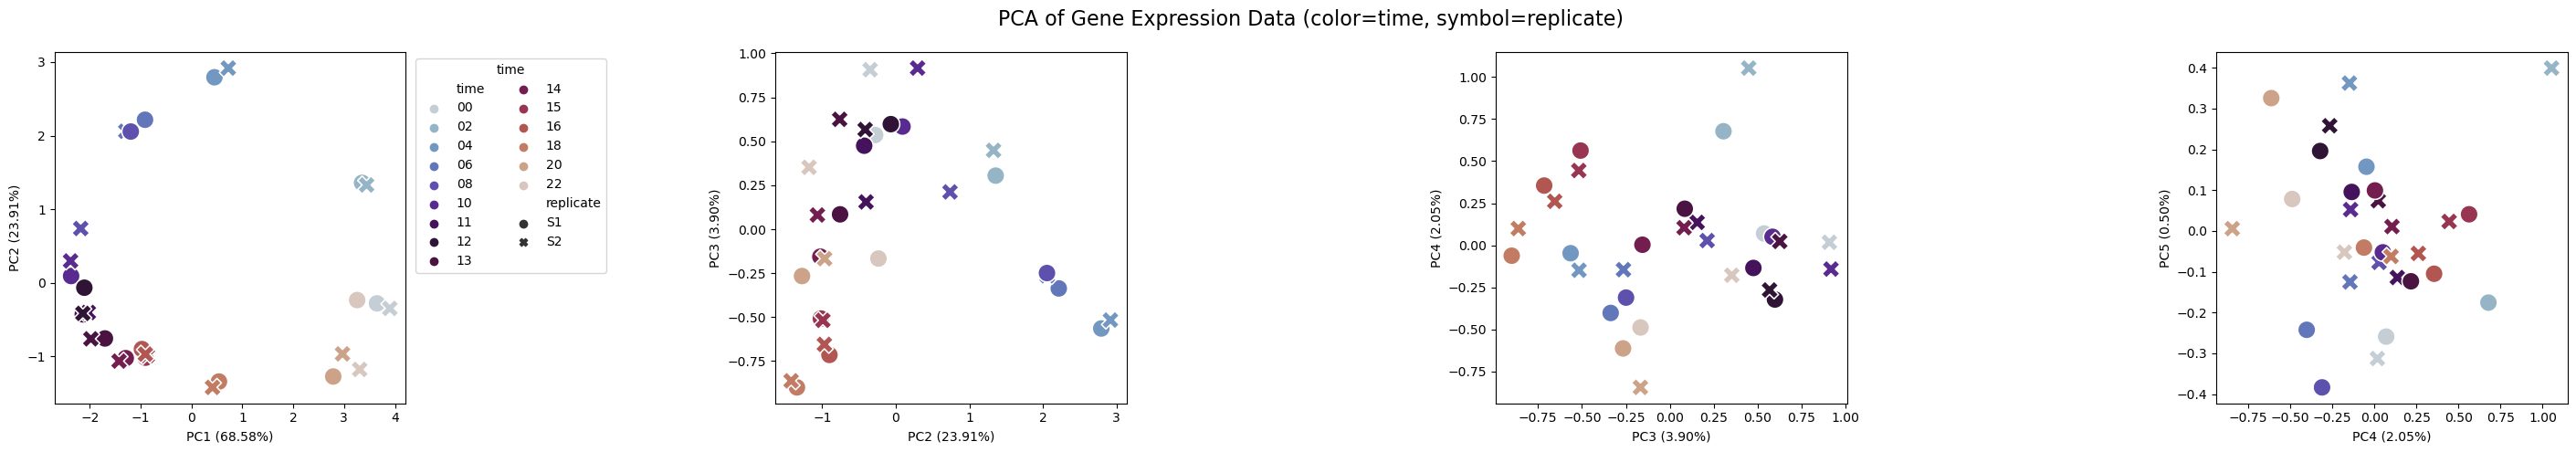

In [4]:
circa_genes = ['Arntl', 'Npas2', 'Clock', 'Cry1', 'Cry2', 'Per1', 'Per2', 'Per3', 'Nr1d1', 'Nr1d2', 'Rora', 'Rorc', 'Tef', 'Dbp','Ciart']

pca_liver_exon = run_PCA(dat_exon_liver.loc[circa_genes], color_by='time', symbol_by='replicate')




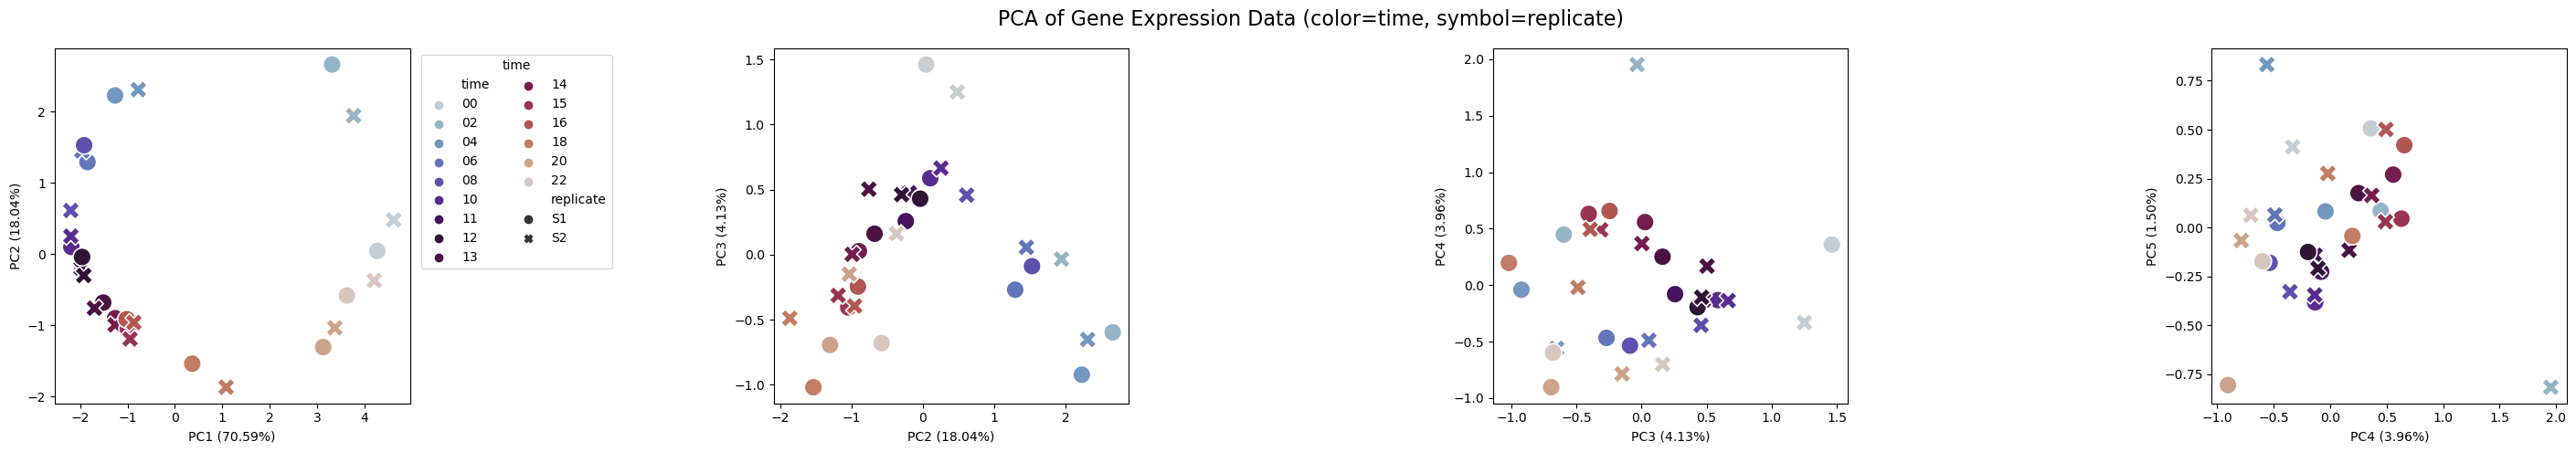

In [6]:
pca_liver_intron = run_PCA(dat_intron_liver.loc[circa_genes], color_by='time', symbol_by='replicate') 

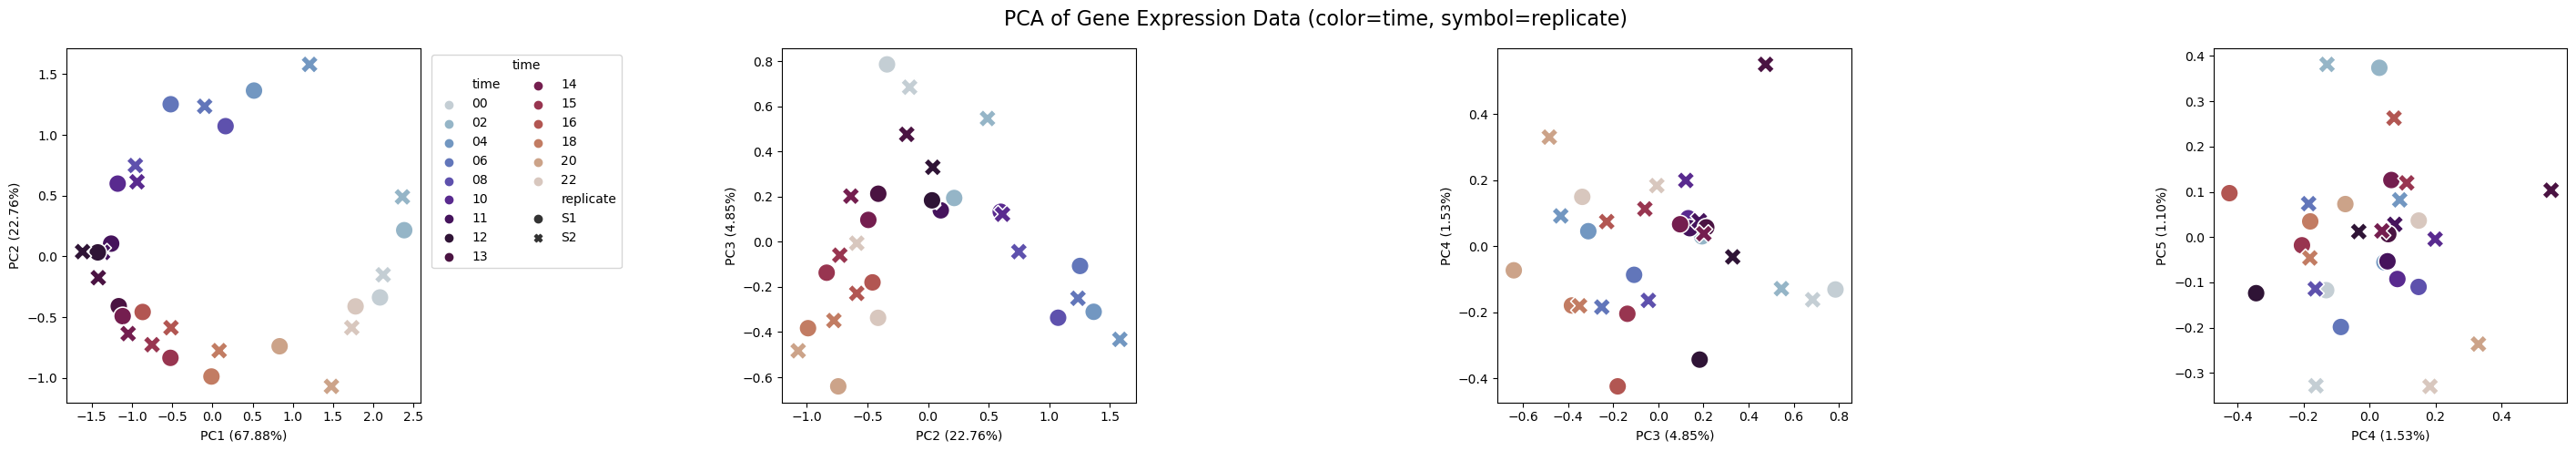

In [7]:
pca_muscle_exon = run_PCA(dat_exon_muscle.loc[circa_genes], color_by='time', symbol_by='replicate')

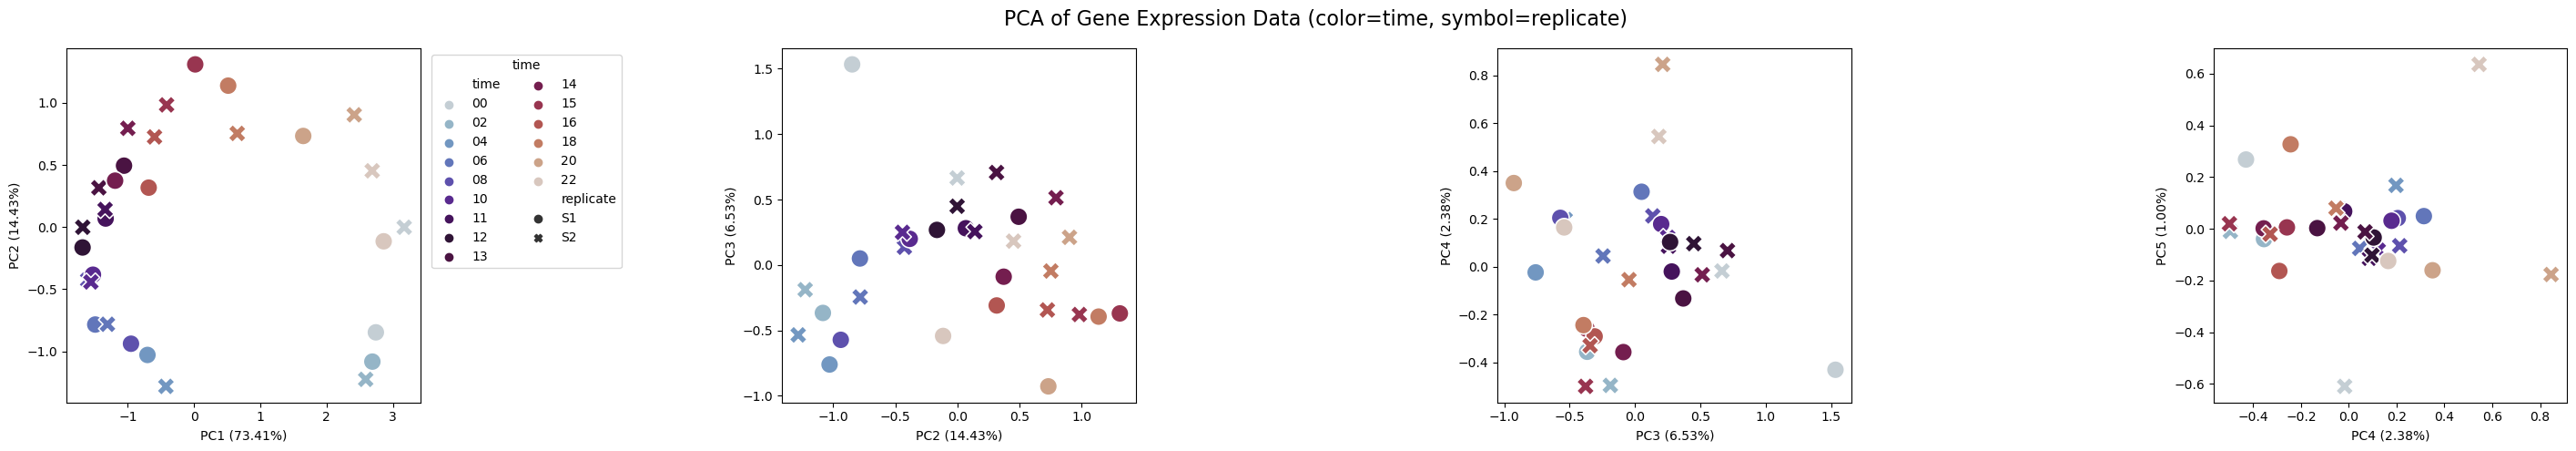

In [8]:
pca_muscle_intron = run_PCA(dat_intron_muscle.loc[circa_genes], color_by='time', symbol_by='replicate')

As we can see the two experiments show similar pattern of circle on the PCA1/PCA2 plot. The different time point follow a circle path in a chronological order (the time series that are close in time modulo $\omega$ appear next to each other).
This show a clear pattern of rythmic expression which would the expected behaviour for a circadian rythm.

#### Assess gene expression rhythmicity genome-wide

In [5]:
# Apply the function to both intron and exon data for both tissues
T = 24
time = dat_exon_liver.columns.get_level_values('time').str.replace('ZT','').astype(int)

results_intron_liver = fit_harmo(dat_intron_liver, time, T)
results_exon_liver = fit_harmo(dat_exon_liver, time, T)
results_intron_muscle = fit_harmo(dat_intron_muscle, time, T)
results_exon_muscle = fit_harmo(dat_exon_muscle, time, T)

/Users/gregoirepachebat/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


#### Define the genes of interest

In [6]:
# Define the genes with significant gene expression rhythm in the liver
gene_liver_intro = np.logical_and(results_intron_liver['q_val'] < 0.05, results_intron_liver['amp'] > 0.5)
gene_liver_exon = np.logical_and(results_exon_liver['q_val'] < 0.05, results_exon_liver['amp'] > 0.5)

# Define the genes with significant gene expression rhythm in the muscle
gene_muscle_intro = np.logical_and(results_intron_muscle['q_val'] < 0.05, results_intron_muscle['amp'] > 0.5)
gene_muscle_exon = np.logical_and(results_exon_muscle['q_val'] < 0.05, results_exon_muscle['amp'] > 0.5)


#### Plot phase and amplitude distribution for the rhythmic genes

In [11]:
results_intron_liver[gene_liver_intro].sort_values('amp', ascending=False)

,mu,amp,phase,p_val,q_val
gene.symb,,,,,
Npas2,-4.141755,8.565445,23.324721,7.414756e-16,2.818843e-12
Dbp,0.941159,6.855408,9.806056,5.689085e-11,1.544858e-08
Nr1d1,0.320824,6.526279,8.328177,2.080334e-14,3.168443e-11
Ciart,-0.523186,6.493392,12.120345,6.339640e-17,3.615180e-13
A530001N23Rik,-3.104968,5.663270,21.237474,9.822765e-09,8.684390e-07
...,...,...,...,...,...
Lyrm4,-0.105443,0.500500,9.762895,2.086221e-04,1.658073e-03
Ufsp2,0.170109,0.500478,18.304245,2.192874e-03,9.671236e-03
Gm17106,-4.844639,0.500313,14.265441,1.744994e-02,4.571911e-02


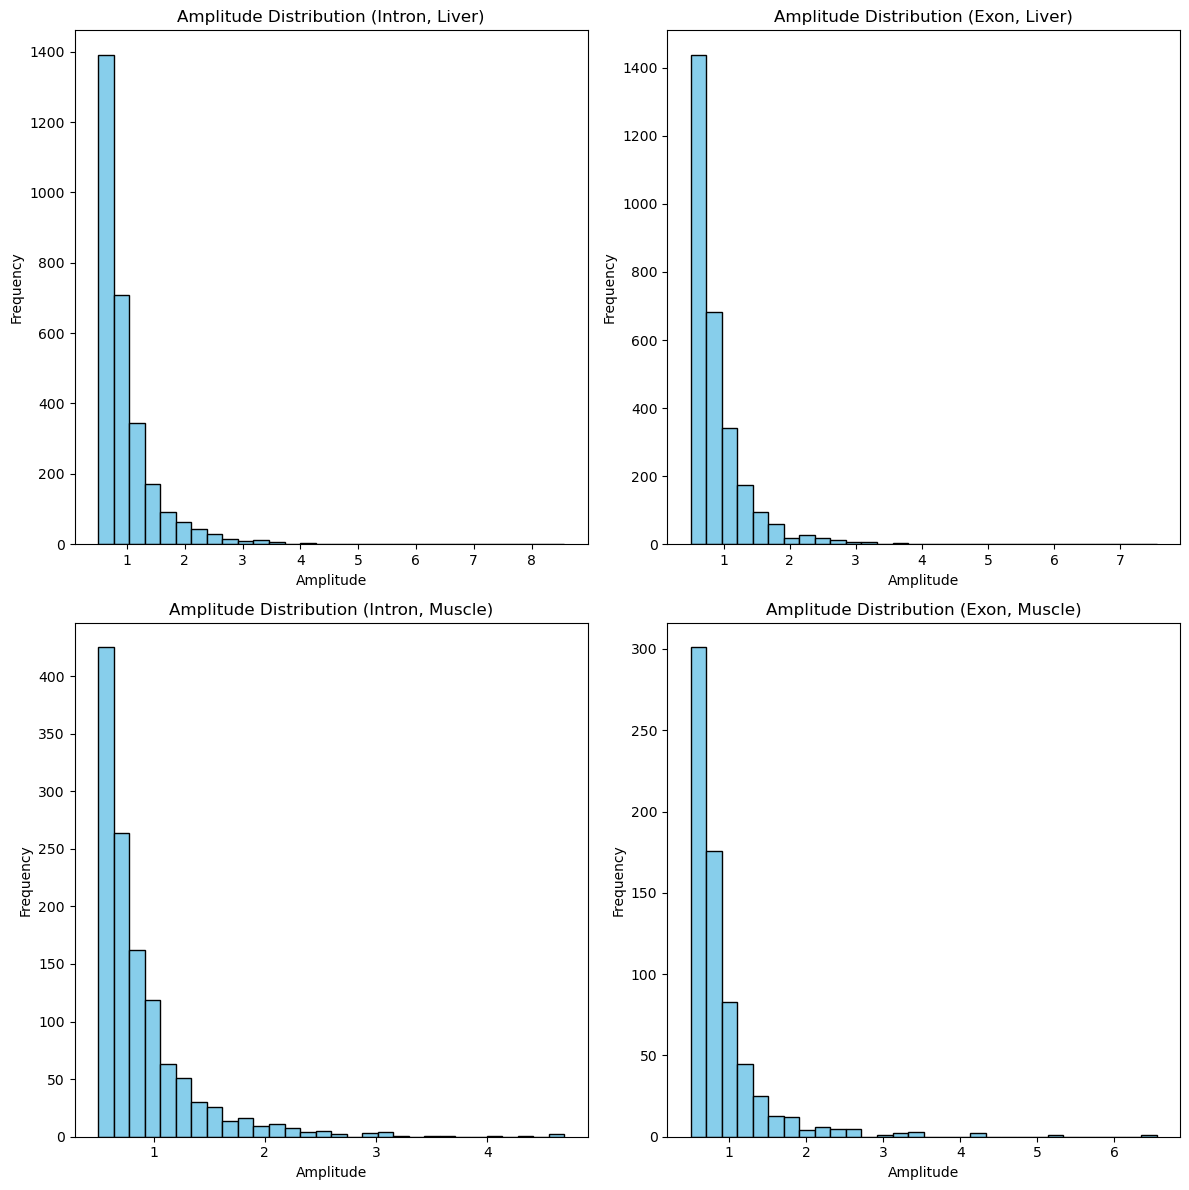

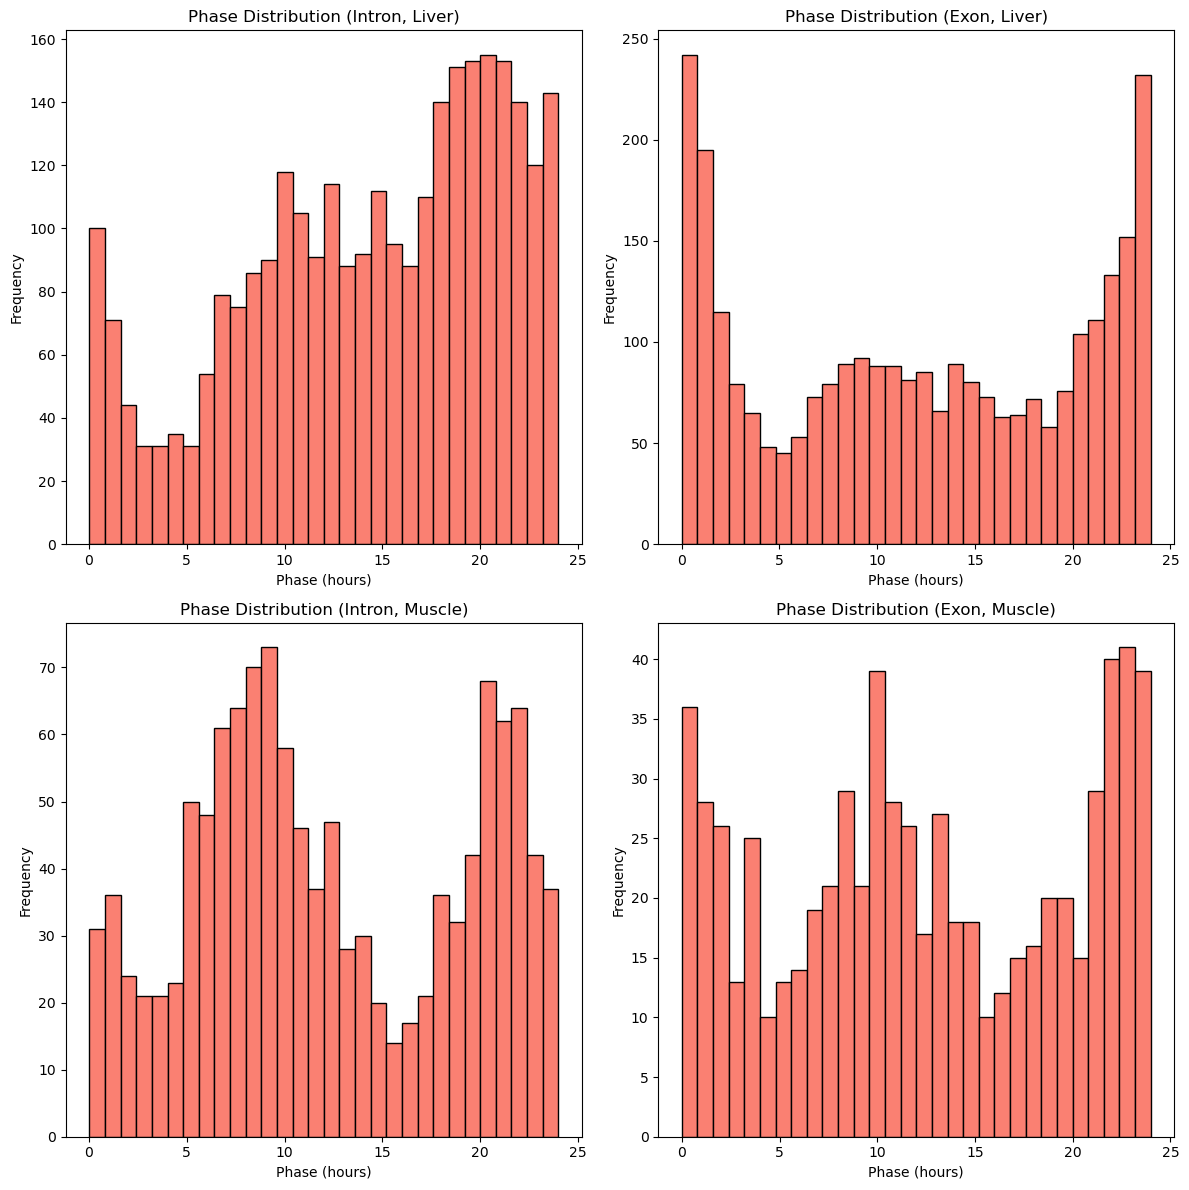

In [11]:
# Filter the results for the genes of interest
filtered_results_liver_intron = results_intron_liver[gene_liver_intro]
filtered_results_liver_exon = results_exon_liver[gene_liver_exon]
filtered_results_muscle_intron = results_intron_muscle[gene_muscle_intro]
filtered_results_muscle_exon = results_exon_muscle[gene_muscle_exon]

# Plot amplitude distributions
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.hist(filtered_results_liver_intron['amp'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.title('Amplitude Distribution (Intron, Liver)')

plt.subplot(2, 2, 2)
plt.hist(filtered_results_liver_exon['amp'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.title('Amplitude Distribution (Exon, Liver)')

plt.subplot(2, 2, 3)
plt.hist(filtered_results_muscle_intron['amp'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.title('Amplitude Distribution (Intron, Muscle)')

plt.subplot(2, 2, 4)
plt.hist(filtered_results_muscle_exon['amp'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.title('Amplitude Distribution (Exon, Muscle)')

plt.tight_layout()
plt.show()

# Plot phase distributions
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.hist(filtered_results_liver_intron['phase'], bins=30, color='salmon', edgecolor='black')
plt.xlabel('Phase (hours)')
plt.ylabel('Frequency')
plt.title('Phase Distribution (Intron, Liver)')

plt.subplot(2, 2, 2)
plt.hist(filtered_results_liver_exon['phase'], bins=30, color='salmon', edgecolor='black')
plt.xlabel('Phase (hours)')
plt.ylabel('Frequency')
plt.title('Phase Distribution (Exon, Liver)')

plt.subplot(2, 2, 3)
plt.hist(filtered_results_muscle_intron['phase'], bins=30, color='salmon', edgecolor='black')
plt.xlabel('Phase (hours)')
plt.ylabel('Frequency')
plt.title('Phase Distribution (Intron, Muscle)')

plt.subplot(2, 2, 4)
plt.hist(filtered_results_muscle_exon['phase'], bins=30, color='salmon', edgecolor='black')
plt.xlabel('Phase (hours)')
plt.ylabel('Frequency')
plt.title('Phase Distribution (Exon, Muscle)')

plt.tight_layout()
plt.show()
#

We can clearly see pattern of expression. The phase distribution show that waves of gene activate themselves only at certain time.

### Question 2

1. Related to Exercise 1, study the relationship between the peak times (i.e., phase) of pre-mRNA and mRNA for genes that exhibit rhythmic behavior at both the pre-mRNA and mRNA levels in each tissue independently. Use appropriate cutoffs in your analysis to select a subset of genes that are rhythmic at both the pre-mRNA and mRNA levels. Aim to include several hundred genes for a robust analysis.  
   **Hint:** Show a scatter plot of mRNA vs. pre-mRNA peak times. Explain your findings.

2. Show representative profiles of genes with short or long delays between the pre-mRNA and mRNA peak times.

3. From the delay between the pre-mRNA and mRNA ($\delta t$ [hr]), infer the mRNA half-life ($\tau$ [hr]) using the formula derived in the course:  


   $$\tan\left(\frac{2\pi \cdot \delta t}{24}\right) = \frac{24}{2\pi}  \frac{ \tau}{\ln(2)}$$
 

   Plot the histogram of the inferred mRNA half-lives for each tissue. Explain your findings.

4. For the selected genes that are common between muscle and liver, compare their mRNA half-lives. Show representative profiles of genes with tissue-specific half-lives. 

5. **(Bonus):** What can you infer about the splicing rate?  





#### Plot pre-mRNA, mRNA delay

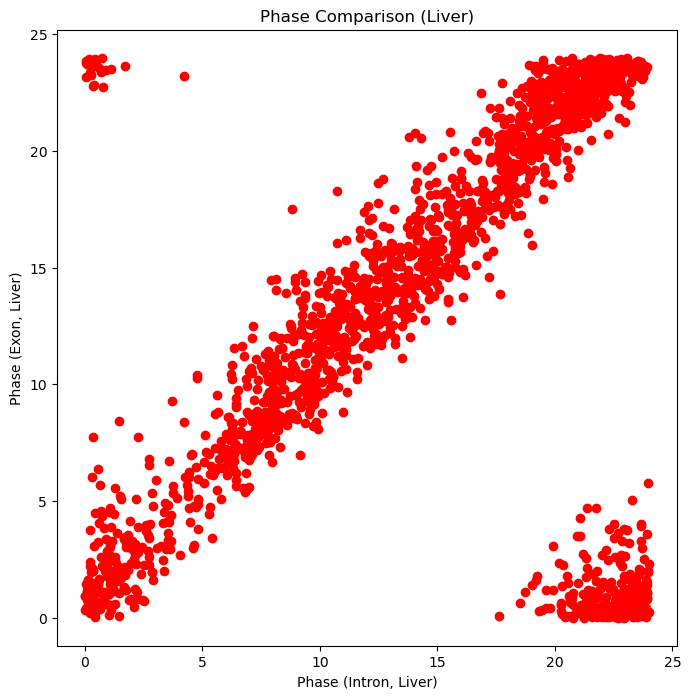

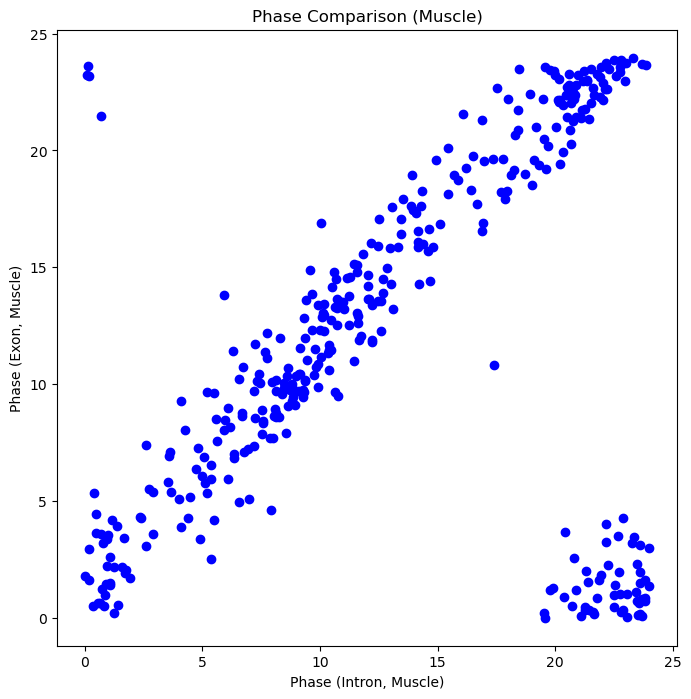

In [7]:

#plot phase intron vs phase exon for gene_liver
#...
# scatter plot of phase intron vs phase exon for liver genes
gene_liver = np.logical_and(gene_liver_intro, gene_liver_exon)
refiltered_results__intron_liver = results_intron_liver[gene_liver]
refiltered_results__exon_liver = results_exon_liver[gene_liver]
plt.figure(figsize=(8, 8))
plt.scatter(refiltered_results__intron_liver['phase'], refiltered_results__exon_liver['phase'], color='red')
plt.xlabel('Phase (Intron, Liver)')
plt.ylabel('Phase (Exon, Liver)')
plt.title('Phase Comparison (Liver)')
plt.show()


#plot phase intron vs phase exon for ii gene_muscle
#...
#...
gene_muscle = np.logical_and(gene_muscle_intro, gene_muscle_exon)
refiltered_results__intron_muscle = results_intron_muscle[gene_muscle]
refiltered_results__exon_muscle = results_exon_muscle[gene_muscle]

# scatter plot of phase intron vs phase exon for muscle genes
plt.figure(figsize=(8, 8))
plt.scatter(refiltered_results__intron_muscle['phase'], refiltered_results__exon_muscle['phase'], color='blue')
plt.xlabel('Phase (Intron, Muscle)')
plt.ylabel('Phase (Exon, Muscle)')
plt.title('Phase Comparison (Muscle)')
plt.show()



### Plot representative genes with short or long-delay

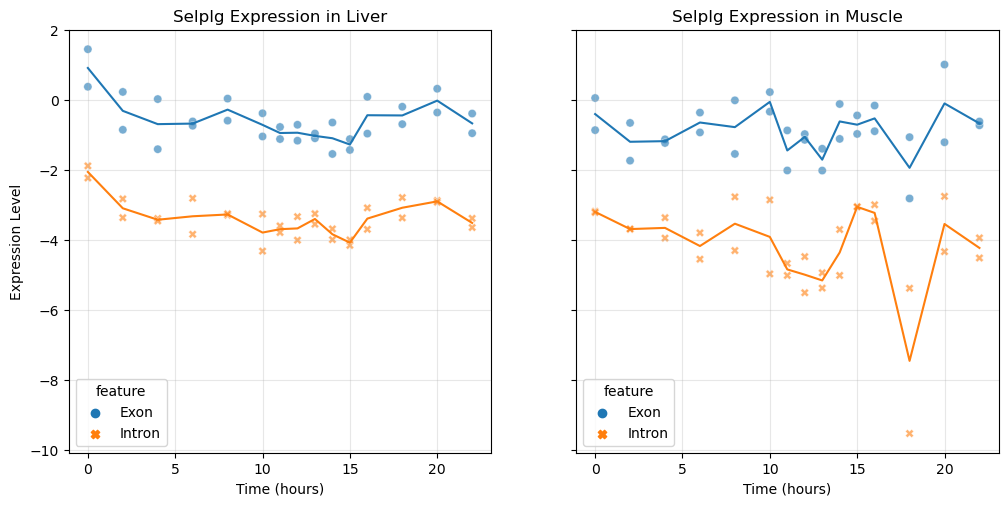

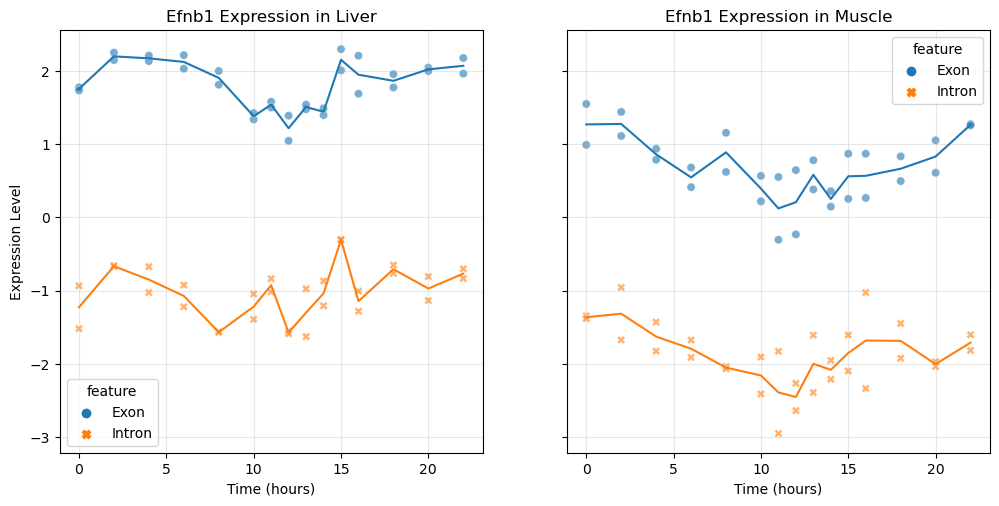

Index(['N4bp3', 'Slc19a1', 'Kpnb1', 'Smo', 'Tspan33', 'Crot', 'Mmd', 'Ddx39',
       'Por', 'Mthfd2',
       ...
       'Bnip3', 'Gm15411', 'Gm15787', 'Gm19522', 'Gm49510', 'Gm45716',
       'Gm45883', 'Nup62', 'Gm45208', '1700028E10Rik'],
      dtype='object', name='gene.symb', length=128)


In [ ]:
#compute the delay between intron and exon for liver and muscle
#restrict to genes with phase difference < 6 hours and with exon later than intron
liver_phase_diff = refiltered_results__exon_liver['phase'] - refiltered_results__intron_liver['phase']
muscle_phase_diff = refiltered_results__exon_muscle['phase'] - refiltered_results__intron_muscle['phase']

#find gene with shortest delay in muscle and liver, plot representative gene expression
#plot_gene_expression(dat_melted, "GeneName")
min_liver = liver_phase_diff.idxmin()
min_muscle = muscle_phase_diff.idxmin()

plot_gene_expression(dat_melted, min_liver)
plot_gene_expression(dat_melted, min_muscle)

#find gene with delay between 3 and 4 hours in muscle and liver
#plot_gene_expression(dat_melted, "GeneName")
genes_between_3_and_4_liver = liver_phase_diff[(liver_phase_diff > 3) & (liver_phase_diff < 4)].index
genes_between_3_and_4_muscle = muscle_phase_diff[(muscle_phase_diff > 3) & (muscle_phase_diff < 4)].index
    

### Compute half-life from the delay between intron and exon


In [ ]:
#...
#...
#...
#...


### Compare half-lives between muscle and liver

In [ ]:
#...
#...
#...
#...


### Plot representative genes with tissue-specific half-life

In [ ]:
#...
#...

#plot_gene_expression(dat_melted, 'GeneName')
 